In [1]:
# 설치 필요
# !pip install yfinance
# !pip install selenium
# !pip install pmdarima

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import pmdarima as pm
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [2]:
##### 매매수익 데이터프레임 전처리

df1 = pd.read_csv("data/NH_CONTEST_NW_FC_STK_IEM_IFO.csv", encoding='euc-kr')
df6 = pd.read_csv('data/NH_CONTEST_DATA_ETF_HOLDINGS.csv', encoding='euc-kr')

# df1 필요없는 컬럼 삭제
drop_c1 = ['fc_sec_krl_nm','fc_sec_eng_nm','stk_etf_dit_cd','ltg_tot_stk_qty','fc_mkt_dit_cd',
           'co_adr','web_adr','btp_cfc_nm','ceo_nm','eng_utk_otl_cts','ids_nm']
df1.drop(columns=drop_c1, axis=1, inplace=True)

# df6 필요없는 컬럼 삭제
drop_c6 = ['fc_sec_eng_nm','stk_qty','mkt_vlu','fc_sec_krl_nm','sec_tp']
df6.drop(columns=drop_c6, axis=1, inplace=True)

# df1과 df6 합치기
merge = pd.merge(df6, df1, on='tck_iem_cd', how='left')

# 'tck_iem_cd' == '-' -> 나머지 컬럼들 '-'로 대체 (티커를 애초에 알 수 없음)
merge.loc[merge['tck_iem_cd'] == '-'] = merge.loc[merge['tck_iem_cd'] == '-'].fillna('-')

merge.to_excel(f'merge_original', index=False)

In [3]:
# merge_nan: 'ser_cfc_nm'가 결측치인 행들만 추출
filter1 = (merge['ser_cfc_nm'].isna()==True)
merge_nan = merge[filter1]

# 행 중복 삭제
merge_nan = merge_nan[['tck_iem_cd','ser_cfc_nm','mkt_pr_tot_amt']].drop_duplicates().reset_index(drop=True)

merge_nan.to_excel(f'merge_nan_original', index=False)

In [6]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from tqdm import tqdm
import time
import csv
from selenium.common.exceptions import NoSuchElementException, TimeoutException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.service import Service

# 크롤링 사이트 - yahoo finance
s = Service(r"C:\chromedriver-win64\chromedriver.exe")
driver = webdriver.Chrome(service=s)
driver.get(f"https://finance.yahoo.com")

In [7]:
ndf = pd.read_excel('merge_nan_original.xlsx')

# 행에 결측치가 있는 'tck_iem_cd' list로 저장
tck_lst = ndf.loc[ndf['ser_cfc_nm'].isna() | ndf['mkt_pr_tot_amt'].isna(), 'tck_iem_cd'].tolist()

# 크롤링 함수 정의
def crawl(t):
    wait = WebDriverWait(driver, 5)

    # yahoo finance 검색창에 전달받은 'tck_iem_cd' 검색
    q = driver.find_element(By.XPATH,'//*[@id="ybar-sbq"]')
    q.send_keys(t)
    q.send_keys('\n')
    time.sleep(2)

    # 'mkt_pr_tot_amt' 크롤링 - Summary에서 Market Cap (intraday) / 없으면 'NONE'
    try:
        mkt_tot = wait.until(EC.visibility_of_element_located((By.XPATH, '//*[@id="nimbus-app"]/section/section/section/article/div[2]/ul/li[9]/span[2]/fin-streamer'))).text  # 시가총액
    except:
        mkt_tot = 'NONE'
    time.sleep(2)
    
    # 'ser_cfc_nm' 크롤링 - Profile에서 Sector / 없으면 'NONE'
    try:
        # yahoo finance Profile 클릭
        wait.until(EC.visibility_of_element_located((By.XPATH, '//*[@id="nimbus-app"]/section/section/aside/section/nav/ul/li[7]/a/span'))).click()
        time.sleep(2)
        sector = wait.until(EC.visibility_of_element_located((By.XPATH, '//*[@id="nimbus-app"]/section/section/section/article/section[2]/section[2]/div/dl/div[1]/dd/a'))).text
    except:
        sector = 'NONE'
    
    time.sleep(2)

    return (mkt_tot, sector)

In [ ]:
# tck_lst에서 하나씩 'tck_iem_cd' 전달받아 크롤링 진행 -> cdf에 값 넣어줌
for tck in tqdm(tck_lst):
    try:
        try:
            c = crawl(tck)
            ndf.loc[ndf['tck_iem_cd'] == tck, ['mkt_pr_tot_amt', 'ser_cfc_nm']] = c # 해당 티커에 크롤링 값 넣어줌
        except Exception as e:
            pass
        driver.back()
        time.sleep(2)

    # 해당 에러 뜨면 그전까지 업데이트된 cdf 엑셀로 저장
    except (TimeoutException, KeyboardInterrupt):
        ndf.to_excel(f'crawling_nan.xlsx', index=False)
        print('save !')

ndf.to_excel(f'crawling_nan.xlsx', index=False)
print('save !')

In [24]:
cdf = pd.read_excel('crawling_nan.xlsx')
odf = pd.read_excel('merge_original.xlsx')

# 크롤링이 완료된 cdf의 값들을 odf에 넣어주기 (결측치 대체)
newdf = odf.merge(cdf[['tck_iem_cd', 'ser_cfc_nm', 'mkt_pr_tot_amt']], on='tck_iem_cd', how='left', suffixes=('', '_new'))
newdf['ser_cfc_nm'] = newdf['ser_cfc_nm'].fillna(newdf['ser_cfc_nm_new'])
newdf['mkt_pr_tot_amt'] = newdf['mkt_pr_tot_amt'].fillna(newdf['mkt_pr_tot_amt_new'])
newdf.drop(columns=['ser_cfc_nm_new', 'mkt_pr_tot_amt_new'], inplace=True)

# 전처리 - 'mkt_pr_tot_amt' 숫자 int 형으로 변환 함수
# 크롤링하면 M, B, T 가 숫자에 붙어서 나옴 (M -> 그대로 숫자만, B -> 공 3개, T -> 공 6개)
def convert_amount(value):
    if value in ['-', 'NONE', '--', np.nan]:
        return '-'
    value = str(value).replace(',', '')
    if 'M' in value:
        return int(round(float(value.replace('M', '')))) # 그대로
    elif 'B' in value:
        return int(round(float(value.replace('B', '')) * 1000)) # 공 3개
    elif 'T' in value:
        return int(round(float(value.replace('T', '')) * 1000000)) # 공 6개
    else:
        return int(round(float(value)))  # 크롤링이 아닌 원래 있던 나머지 숫자는 반올림하여 정수 변환

# 함수 적용
newdf['mkt_pr_tot_amt'] = newdf['mkt_pr_tot_amt'].apply(convert_amount)

# 크롤링으로 결측치가 채워지고 전처리된 "최종 df" newdf 엑셀파일로 저장
newdf.to_excel('newdf.xlsx', index=False)

##### 여기까지가 매매수익 파트 데이터프레임 전처리 및 크롤링 완료
##### 크롤링 시간이 오래 걸리기 때문에 완성된 데이터프레임을 구글 드라이브로 보내드립니다!

-----

In [4]:
##### 배당수익 데이터프레임 전처리

dividend_data = pd.read_csv('data/NH_CONTEST_DATA_HISTORICAL_DIVIDEND.csv')

# 티커(Ticker)를 기준으로 두 데이터를 병합 (티커 열의 대소문자 및 공백 문제 해결 포함)
dividend_data['etf_tck_cd'] = dividend_data['etf_tck_cd'].str.strip()

dividend_data_renamed = dividend_data.rename(columns={
    'etf_tck_cd': 'ETF_티커',
    'ediv_dt': '배당락일',
    'ddn_amt': '배당금',
    'aed_stkp_ddn_amt': '수정_배당금',
    'ddn_bse_dt': '배당기준일',
    'ddn_pym_dt': '배당지급일',
    'pba_dt': '공시일',
    'ddn_pym_fcy_cd': '배당주기'
})

dividend_data_renamed['배당락일'] = pd.to_datetime(dividend_data_renamed['배당락일'], format='%Y%m%d')

# ETF별로 연도별 배당금 집계
dividend_data_renamed['배당연도'] = dividend_data_renamed['배당락일'].dt.year

# CAGR 계산 함수
def calculate_cagr(start_value, end_value, periods):
    if periods == 0:  
        return 0
    return (end_value / start_value) ** (1 / periods) - 1

# ETF별로 배당 성장률 계산 및 기존 데이터프레임에 추가
def calculate_and_add_dividend_growth_rate(df):
    df_sorted = df.sort_values(by=['ETF_티커', '배당락일'])
    grouped = df_sorted.groupby('ETF_티커').agg(
        초기배당금=('배당금', 'first'),
        최종배당금=('배당금', 'last'),
        배당기간=('배당연도', lambda x: x.max() - x.min() + 1))
    grouped['연평균배당성장률'] = grouped.apply(
        lambda row: calculate_cagr(row['초기배당금'], row['최종배당금'], row['배당기간']), axis=1)
    df_with_growth = pd.merge(df, grouped[['연평균배당성장률']], on='ETF_티커', how='left')
    return df_with_growth

# 연평균 배당 성장률 계산 후 기존 데이터프레임에 추가
dividend_data_renamed = calculate_and_add_dividend_growth_rate(dividend_data_renamed)

# 각 ETF별로 배당 정보를 평균으로 계산하는 함수
def calculate_dividend_averages(dividend_data):
    # ETF 티커별로 배당 정보의 평균값 계산
    avg_dividend_data = dividend_data.groupby('ETF_티커').agg({
        '배당금': 'mean',
        '수정_배당금': 'mean',
        '배당주기': 'first',
          '연평균배당성장률' : 'mean'  # 배당주기는 보통 일정하므로 첫 값을 사용
    }).reset_index()
    
    return avg_dividend_data

avg_dividend_data = calculate_dividend_averages(dividend_data_renamed)

dividend_mapping = {
    'Quarterly': '3개월',
    'SemiAnnual': '6개월',
    'Annual': '1년',
    'Monthly': '1개월',
    'Other' : '기타'
}
avg_dividend_data['배당주기'] = avg_dividend_data['배당주기'].map(dividend_mapping)

-----

In [5]:
# 시각화 색깔 매핑 {ser_cfc_nm : color}
color_mapping = {
    'Technology': 'lightskyblue',        
    'Real Estate': 'goldenrod',        
    'Consumer Cyclical': 'violet', 
    'Healthcare': 'springgreen', 
    'Communication Services': 'lightpink', 
    'Industrials': 'gray', 
    'Financial Services': 'orange',
    'Basic Materials': 'royalblue',         
    'Consumer Defensive': 'aquamarine', 
    'Utilities': 'slateblue',  
    'Energy': 'yellow',     
    'Financial': 'lightsalmon',
    '-': 'white',
    'NONE': 'white'
}

In [6]:
##### ETF 큐레이션에 필요한 서비스 함수 정의

# 서비스1. 특정 sector가 많이 포함되어 있는 etf 추천해줘~
def service1(sec, percent=0, cnt=100):
    df = pd.read_excel('newdf.xlsx')
    sec_df = df[df['ser_cfc_nm'] == sec]
    groupby_df = sec_df.groupby(['etf_tck_cd'])[['wht_pct']].sum().reset_index()
    per_df = groupby_df[groupby_df['wht_pct'] > percent]
    sort_df = per_df.sort_values(by='wht_pct', ascending=False).reset_index()[:cnt]
    print(sort_df[['etf_tck_cd','wht_pct']])
    return sort_df['etf_tck_cd'].tolist()

In [7]:
# 서비스2. 특정 주식이 포함되어 있는 etf 추천해줘~
def service2(tck_cd, percent=0, cnt=100):
    df = pd.read_excel('newdf.xlsx')
    tck_df = df[df['tck_iem_cd'] == tck_cd]
    per_df = tck_df[tck_df['wht_pct'] > percent]
    sort_df = per_df.sort_values(by='wht_pct', ascending=False).reset_index()[:cnt]
    print(sort_df[['etf_tck_cd', 'wht_pct']])
    return sort_df['etf_tck_cd'].tolist()

In [8]:
# 서비스3. ETF 별 NAV 시각화 (막대그래프)
def service3(ticker_codes):
    df = pd.read_excel('newdf.xlsx')
    filtered_df = df[df['etf_tck_cd'].isin(ticker_codes)]
    filtered_df['mkt_pr_tot_amt'] = pd.to_numeric(filtered_df['mkt_pr_tot_amt'], errors='coerce').fillna(0)
    grouped_data = filtered_df.groupby(['etf_tck_cd', 'ser_cfc_nm'])['mkt_pr_tot_amt'].sum().unstack(fill_value=0)
    grouped_data['total'] = grouped_data.sum(axis=1)
    grouped_data = grouped_data.sort_values('total', ascending=False).drop('total', axis=1)
    
    fig_width = max(20, 4 * len(ticker_codes))
    plt.figure(figsize=(fig_width, 15))
    ax = grouped_data.plot(kind='bar', stacked=True, color=[color_mapping.get(nm, '#333333') for nm in grouped_data.columns], 
                           edgecolor='black', linewidth=0.5)
    plt.title('Total Market Price by ETF Ticker Code and Service Classification')
    plt.xlabel('ETF Ticker Code')
    plt.ylabel('Total Market Price (mkt_pr_tot_amt)')
    plt.xticks(rotation=45)
    plt.legend(title='Service Classification', loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True)
    return plt.show()


In [9]:
# 서비스4. 변동성 대비 수익률 그래프 시각화 (4분면)
def service4(tck_list, period=1):
    etf_hld = pd.read_csv('data/NH_CONTEST_DATA_ETF_HOLDINGS.csv',encoding='euc-kr')
    today = datetime.today()
    end_date = today.strftime('%Y-%m-%d')
    target_day = today - relativedelta(months=period)
    start_date = target_day.strftime('%Y-%m-%d')
    
    # 분산과 수익률 구하기
    vars = []
    returns = []
    for tck in tck_list:
        yfs = yf.download(tck, start=start_date, end=end_date, progress=False)[['Open','Close']]
        yfs.loc[:, 'Open'] = yfs['Open'].round(2)
        yfs.loc[:, 'Close'] = yfs['Close'].round(2)

        # 분산 계산
        vars.append(yfs['Close'].var())
        
        # 수익률 계산
        start_price = yfs['Open'].iloc[0]  # 목표날의 시가
        end_price = yfs['Close'].iloc[-1]  # 오늘의 종가
        return_rate = ((end_price / start_price)-1) * 100
        returns.append(return_rate)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(vars, returns, color='blue')
    for i, tck in enumerate(tck_list):
        plt.text(vars[i]+2, returns[i]+1, tck, fontsize=11, ha='right', va='bottom')
    plt.axhline(y=0, color='r', linestyle='--', label='y 절편 : 0')
    plt.axvline(x=np.mean(vars), color='g', linestyle='--', label='x 절편 : 평균')
    plt.title(f'{period}개월 간의 수익률 변동성 비교')
    plt.xlabel('변동성 (분산)')
    plt.ylabel('수익률 (%)')
    plt.legend(loc='upper left')
    plt.grid()
    x_margin = max(vars-np.mean(vars))+10
    plt.xlim(np.mean(vars)-x_margin, np.mean(vars)+x_margin)  
    plt.ylim(-(max(returns)+10), max(returns)+10)  
    return plt.show()

In [10]:
# 서비스5. 배당 성장률, 배당 수익률, 배당 주기 기준 선호도에 따라서 etf 추천해줘~

# 배당 수익률을 연간 배당 수익률로 환산하는 함수
def calculate_annual_dividend_yield(avg_dividend_data):
    avg_dividend_data['연간_배당수익률'] = avg_dividend_data.apply(
        lambda row: row['배당금'] * 12 if row['배당주기'] == '1개월' else
                    row['배당금'] * 4 if row['배당주기'] == '3개월' else
                    row['배당금'] * 2 if row['배당주기'] == '6개월' else
                    row['배당금'] * 1 if row['배당주기'] == '1년' else
                    row['배당금'],  
        axis=1)
    return avg_dividend_data

def service5():
    priority = input('우선순위를 선택하세요. 1 : 배당성장률 2 : 배당수익률')
    dividend_level = input('배당수익률 중요도를 선택하세요. : 높음, 낮음, 없음')
    dividend_period = input('배당 주기를 선택하세요 : 1개월, 3개월, 6개월, 1년')
    growth_level = input('배당성장률 중요도를 선택하세요 : 높음, 낮음')
    global avg_dividend_data

    # 연간 배당 수익률 계산
    avg_dividend_data = calculate_annual_dividend_yield(avg_dividend_data)

    # 우선순위에 따른 정렬
    if priority == '1':

        # 배당 성장률을 먼저 정렬
        if growth_level == '높음':
            avg_dividend_data = avg_dividend_data.sort_values(by='연평균배당성장률', ascending=False)
        elif growth_level == '낮음':
            avg_dividend_data = avg_dividend_data.sort_values(by='연평균배당성장률', ascending=True)
        elif growth_level is not None:
            return "잘못된 배당 성장률 기준입니다. '높음', '낮음' 중 하나를 선택하세요."
        
        # 배당 성향에 따른 정렬을 두 번째로 수행
        if dividend_level == '높음':
            sorted_etfs = avg_dividend_data.sort_values(by='연간_배당수익률', ascending=False)
        elif dividend_level == '낮음':
            sorted_etfs = avg_dividend_data.sort_values(by='연간_배당수익률', ascending=True)
        elif dividend_level == '없음':
            sorted_etfs = avg_dividend_data[avg_dividend_data['배당금'] == 0]
        else:
            return "잘못된 배당 성향입니다. '높음', '낮음', '없음' 중 하나를 선택하세요."
    
    elif priority == '2':

        # 배당 수익률을 먼저 정렬
        if dividend_level == '높음':
            avg_dividend_data = avg_dividend_data.sort_values(by='연간_배당수익률', ascending=False)
        elif dividend_level == '낮음':
            avg_dividend_data = avg_dividend_data.sort_values(by='연간_배당수익률', ascending=True)
        elif dividend_level == '없음':
            avg_dividend_data = avg_dividend_data[avg_dividend_data['배당금'] == 0]
        else:
            return "잘못된 배당 성향입니다. '높음', '낮음', '없음' 중 하나를 선택하세요."
        
        # 배당 성장률에 따른 정렬을 두 번째로 수행
        if growth_level == '높음':
            sorted_etfs = avg_dividend_data.sort_values(by='연평균배당성장률', ascending=False)
        elif growth_level == '낮음':
            sorted_etfs = avg_dividend_data.sort_values(by='연평균배당성장률', ascending=True)
        elif growth_level is not None:
            return "잘못된 배당 성장률 기준입니다. '높음', '낮음' 중 하나를 선택하세요."
    
    else:
        return "잘못된 우선순위입니다. '배당성장률' 또는 '배당수익률' 중 하나를 선택하세요."

    # 배당 주기가 상관없을 경우 필터링을 하지 않음
    if dividend_period and dividend_period != '상관없음':
        sorted_etfs = sorted_etfs[sorted_etfs['배당주기'] == dividend_period]

    df = sorted_etfs.head(20)
    df_lst = df['ETF_티커'].tolist()
    print(df)
    print('\n')

    return f'추천드리는 ETF는 {df_lst[0]}, {df_lst[1]}, {df_lst[2]} 입니다.'

In [11]:
# 서비스6. 해당 etf 구성 종목 파이차트로 알려줘~
def service6(etf):
    df = pd.read_excel('newdf.xlsx')
    etf_df = df[df['etf_tck_cd'] == etf]
    etf_df = etf_df.sort_values(by='ser_cfc_nm')
    colors = [color_mapping.get(x, '#333333') for x in etf_df['ser_cfc_nm']]
    explode = [0.01] * len(etf_df) 
    plt.figure(figsize=(10, 10))
    patches, texts, autotexts = plt.pie(etf_df['wht_pct'], labels=etf_df['tck_iem_cd'], autopct='%1.1f%%', startangle=90, pctdistance=0.85, 
                                        explode=explode, colors=colors, wedgeprops={'edgecolor': 'black', 'linewidth': 0.5})
    
    for text, autotext in zip(texts, autotexts):
        text.set_fontsize(8)  
        autotext.set_fontsize(8) 
    handles = [plt.Rectangle((0,0),1,1, color=color_mapping[label]) for label in color_mapping]
    plt.legend(handles, color_mapping.keys(), title="Service Classification", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    plt.show()
    return plt

In [12]:
# 입력 기간에 따른 예상 수익률 모델
def model(lst):
    period = int(input('몇 개월 간 보유할 예정인가요? (1,3,6,12) :'))

    today = datetime.today()
    present_date = pd.to_datetime(today).strftime('%Y-%m-%d')
    past_date = (pd.to_datetime(today)-pd.DateOffset(years=2)).strftime('%Y-%m-%d')
    pred_date = (pd.to_datetime(today)+pd.DateOffset(months=period)).strftime('%Y-%m-%d')
    pred_range = pd.Series(pd.date_range(start=present_date, end=pred_date))
    
    pred_returns = []
    for tck in lst:
        yfs = yf.download(tck, start=past_date, end=present_date, progress=False)[['Close']]
        
        kpss_diffs = pm.arima.ndiffs(yfs['Close'], alpha=0.05, test='kpss', max_d=5)
        adf_diffs = pm.arima.ndiffs(yfs['Close'], alpha=0.05, test='adf', max_d=5)
        n_diffs = max(kpss_diffs, adf_diffs)
        model = pm.auto_arima(yfs['Close'], d=n_diffs, seasonal=False)
        
        pred = model.predict(n_period=len(pred_range)).to_list()
        pred_returns.append(pred[-1]/pred[0])

    tck_pred = pd.DataFrame({'ETF':lst,'pred':pred_returns})
    recommand = tck_pred.loc[tck_pred['pred'].idxmax(),'ETF']
    max_return = round((tck_pred['pred'].max()-1) *100, 2)
    return print(f'{period}개월 간 보유하실 예정이시면, 해당 기간의 예상 수익률이 {max_return}%로 가장 높은 {recommand} ETF를 추천합니다.'), service6(recommand)

In [13]:
##### 실제 서비스 구현 프레임워크

# 매매수익 파트
def user_phase1():
    df = pd.read_excel('newdf.xlsx')

    # service1
    sec = str(input("어떤 sector를 포함시키고 싶으신가요? (상관없음 입력 가능): " ).strip())
    if sec == '상관없음':
        s1 = df['etf_tck_cd'].tolist()
    else:
        per = input(f"어느 정도 비중(%)을 포함시키고 싶으신가요? (상관없음 입력 가능): ").strip()
        if per == '상관없음':
            s1 = service1(sec)
        else:
            s1 = service1(sec, float(per))

    print('\n')

    # sevice2
    tck = str(input("어떤 주식을 포함시키고 싶으신가요? 티커를 입력하세요. (상관없음 입력 가능): ").strip())
    if tck == '상관없음':
        return list(s1)
    else:
        per = input("어느 정도 비중(%)을 포함시키고 싶으신가요? (상관없음 입력 가능): ").strip()
        if per == '상관없음':
            s2 = service2(tck)
        else:
            s2 = service2(tck, float(per))

    lst = list(set(s1).intersection(set(s2)))
    print('\n')
    print(lst)

    if len(lst) == 0:
        return user_phase1()

    return lst

In [14]:
##### 실제 서비스 구현 프레임워크

# 매매수익 파트
def user_phase1():
    df = pd.read_excel('newdf.xlsx')

    # service1
    sector = input("어떤 섹터를 포함시키고 싶으신가요? (상관없음 입력 가능): ").strip()
    if sector == '상관없음':
        etf_tickers = df['etf_tck_cd'].tolist()
    else:
        proportion = input(f"{sector} 섹터의 어느 정도 비중(%)을 포함시키고 싶으신가요? (상관없음 입력 가능): ").strip()
        etf_tickers = service1(sector) if proportion == '상관없음' else service1(sector, float(proportion))

    print('\n')

    # service2
    ticker = input("어떤 주식을 포함시키고 싶으신가요? 티커를 입력하세요. (상관없음 입력 가능): ").strip()
    if ticker == '상관없음':
        return etf_tickers
    else:
        proportion = input(f"{ticker}의 어느 정도 비중(%)을 포함시키고 싶으신가요? (상관없음 입력 가능): ").strip()
        stock_tickers = service2(ticker) if proportion == '상관없음' else service2(ticker, float(proportion))

    result_list = list(set(etf_tickers) & set(stock_tickers))
    print('\n', result_list)

    if not result_list:
        return user_phase1()

    return result_list

In [15]:
# 시각화 정보 제공 서비스
def user_phase2(lst):
    period = input("과거 몇개월 간의 성과를 보고 싶으신가요? (상관없음 입력 시 1개월): ").strip()
    if period == '상관없음':
        return service3(lst), service4(lst)
    return service3(lst), service4(lst, int(period))

---

   etf_tck_cd  wht_pct
0         XLK   99.999
1         SMH   99.097
2        SOXQ   99.070
3        SOXX   97.417
4        CLOU   86.992
5        SKYY   86.829
6        CIBR   77.527
7        NVDL   66.832
8        AAPB   66.778
9        AMDL   66.718
10        NVD   66.521
11        AIQ   59.146
12        MGK   53.140
13       GPIQ   52.394
14        QQQ   51.407
15       QYLD   51.401
16       QQQM   51.401
17       SPYG   51.335
18       NUSI   50.338
19       METV   48.758
20        TAN   46.233
21       QCLN   43.398
22       JEPQ   41.073
23       ARKQ   38.460
24       BOTZ   36.578
25       ARKW   35.145
26        VOO   33.445
27       ARKF   32.222
28       SPLG   31.907
29        SPY   31.902
30       XYLD   31.849
31        IVV   31.564
32        VTI   31.539
33       GPIX   31.513


   etf_tck_cd  wht_pct
0        AAPB   66.778
1         MGK   12.510
2        SPYG   12.238
3        GPIQ    9.879
4         QQQ    9.141
5        QYLD    9.140
6        QQQM    9.139
7        

<Figure size 7200x1500 with 0 Axes>

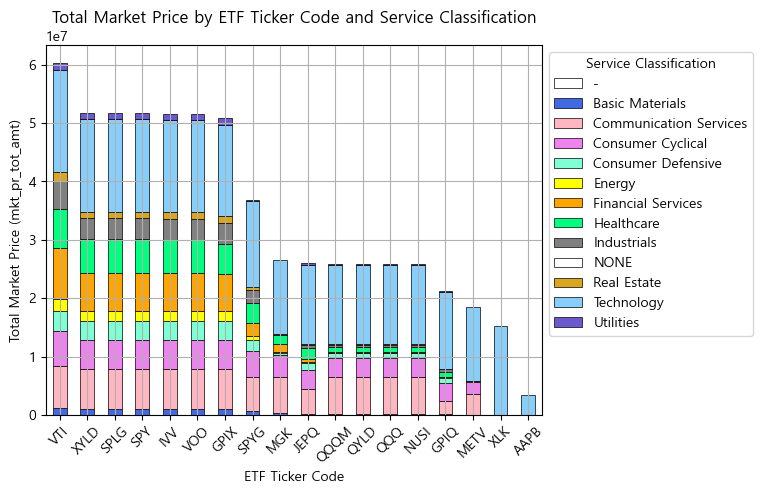

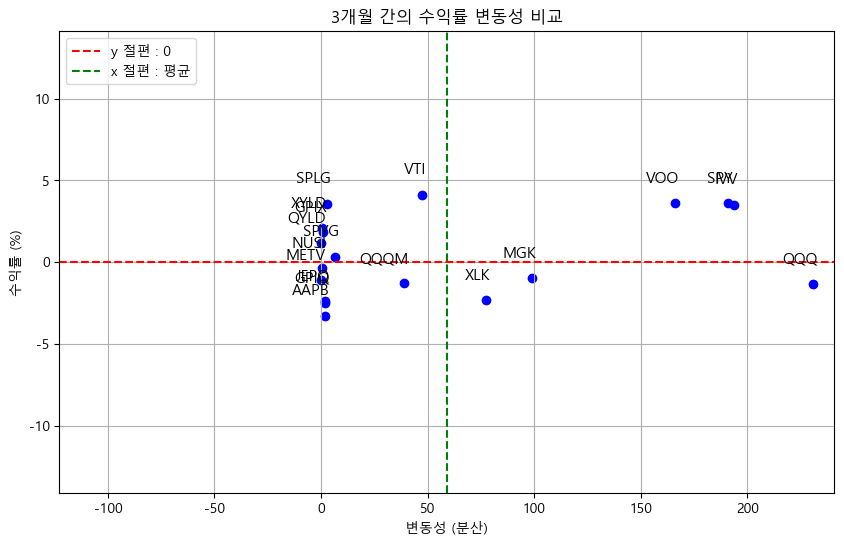

(None, None)


In [22]:
##### 서비스 구현 예시
# 실행시키실 때 아래의 예시로 입력 부탁드립니다.
# 예시 입력: 매매수익 -> Technology -> 30 -> AAPL -> 5 -> 3
# 예시 입력: 배당수익 -> 1 -> 높음 -> 3개월 -> 높음

preference = input("당신은 주가가 올라서 얻는 수익이 중요한가요, 배당으로 안정적인 수익을 얻는 것이 중요한가요? 매매수익 또는 배당수익 중 하나를 입력하세요: ").strip()

if preference == '매매수익':
    lst1 = user_phase1()
    print(user_phase2(lst1))
elif preference == '배당수익':
    print(service5())
else:
    print("잘못된 입력입니다.")

6개월 간 보유하실 예정이시면, 해당 기간의 예상 수익률이 0.82%로 가장 높은 QQQM ETF를 추천합니다.


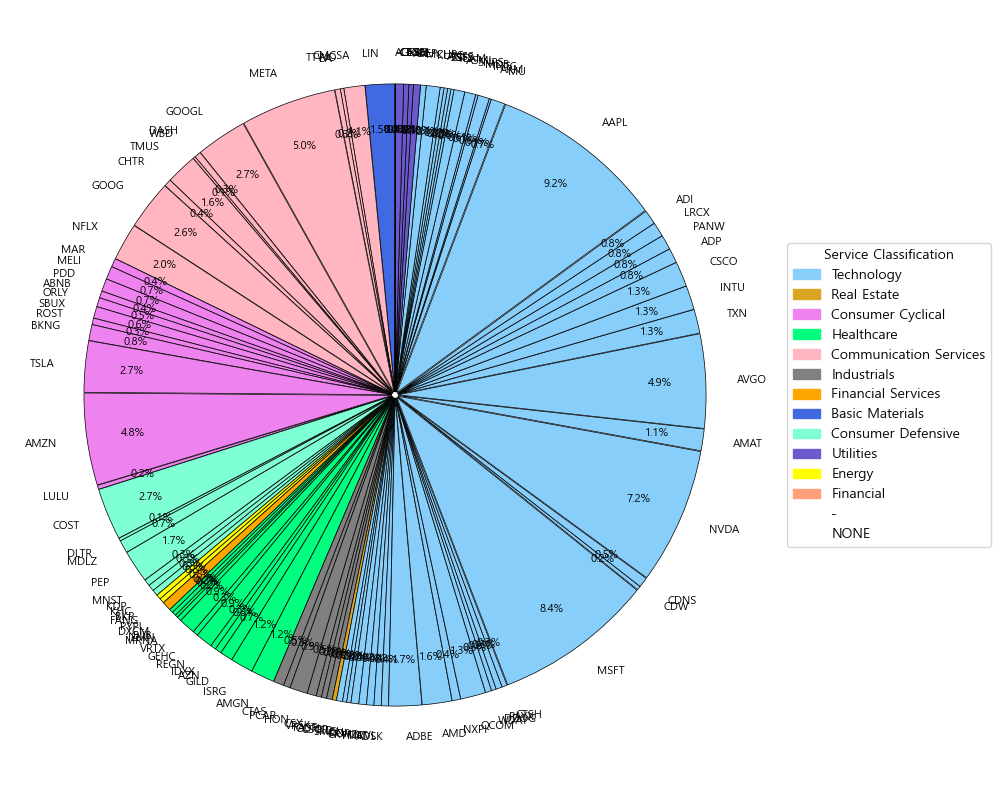

(None,
 <module 'matplotlib.pyplot' from 'c:\\Users\\sinji\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>)

In [17]:
##### 위의 그래프에서 ETF 선택 기능은 챗봇 개발 시 구현 예정
# 사용자가 위 그래프에서 다섯개의 ETF를 선택했다고 가정
model_lst = ['VTI', 'METV', 'QQQM', 'VOO', 'AAPB']
model(model_lst)